# Exercise A - VAEs

In this exercise, you will implement the key mathematical components of a VAE in a controlled setting.

You must implement **three** functions:

1. `reparameterize(mu, logvar)`
2. `kl_diag_gaussian_to_standard(mu, logvar)`
3. `bernoulli_nll_from_logits(logits, x)`

Then you will combine them in a provided `vae_loss` function and run sanity checks.

Rules:
- Do not change the test code.
- Your functions must work for generic batch size $B$ and latent dimension $D$.
- Use $p(z) = \mathcal{N}(0, I)$ and a diagonal Gaussian $q(z \mid x)$.

When you are done, answer the short conceptual questions at the end.


In [ ]:
# --------------------------------
# Setup (do not modify this cell)
# --------------------------------

import torch
import torch.nn.functional as F

# Reproducibility
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Optional: reduce flakiness across some GPU setups (should not matter for this exercise)
if device.type == "cuda":
    torch.cuda.manual_seed_all(0)

def assert_close(a: torch.Tensor, b: torch.Tensor, tol: float, msg: str):
    err = (a - b).abs().max().item()
    assert err <= tol, f"{msg} | max abs error = {err:.4e} > tol = {tol:.4e}"

# Small synthetic "batch"
B, D, P = 64, 5, 32  # batch, latent dim, "pixels/features"
x = torch.bernoulli(torch.full((B, P), 0.3, device=device))  # x in {0,1}
logits = torch.randn(B, P, device=device) * 2.0             # arbitrary logits

mu = torch.randn(B, D, device=device)
logvar = torch.randn(B, D, device=device) * 0.3  # keep variances not too extreme

print(
    "Shapes:",
    "x", x.shape,
    "| logits", logits.shape,
    "| mu", mu.shape,
    "| logvar", logvar.shape,
)


Using device: cpu
Shapes: x torch.Size([64, 32]) | logits torch.Size([64, 32]) | mu torch.Size([64, 5]) | logvar torch.Size([64, 5])


In [ ]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Reparameterization trick.

    Given mu and log-variance, sample:
      z = mu + sigma * eps, where eps ~ N(0, I) and sigma = exp(0.5 * logvar).

    Args:
        mu:     shape [B, D]
        logvar: shape [B, D]

    Returns:
        z: shape [B, D]
    """
    # Hint:
    # 1) Convert log-variance to standard deviation: std = exp(0.5 * logvar)
    # 2) Sample eps ~ N(0, I) with same shape as std (or mu)
    # 3) Return z = mu + std * eps
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + std * eps
    return z # raise NotImplementedError


In [ ]:
# --------------------------------
# Tests (do not modify this cell)
# --------------------------------
torch.manual_seed(123)
B_test, D_test = 50000, 2
mu_test = torch.tensor([[1.5, -0.5]], device=device).expand(B_test, D_test)
sigma2_test = torch.tensor([[0.5, 1.5]], device=device).expand(B_test, D_test)
logvar_test = torch.log(sigma2_test)

z = reparameterize(mu_test, logvar_test)

emp_mean = z.mean(dim=0)
emp_var = z.var(dim=0, unbiased=False)

target_mean = mu_test[0]
target_var = sigma2_test[0]

assert_close(emp_mean, target_mean, tol=3e-2, msg="reparameterize: mean mismatch")
assert_close(emp_var, target_var, tol=5e-2, msg="reparameterize: variance mismatch")

# Gradient sanity check
mu_small = torch.randn(4, 3, device=device, requires_grad=True)
logvar_small = (torch.randn(4, 3, device=device, requires_grad=True) * 0.1).detach().requires_grad_()
z_small = reparameterize(mu_small, logvar_small)
loss = (z_small**2).mean()
loss.backward()

assert torch.isfinite(mu_small.grad).all(), "reparameterize: non-finite grad wrt mu"
assert torch.isfinite(logvar_small.grad).all(), "reparameterize: non-finite grad wrt logvar"

print("OK - reparameterize passed all tests.")

OK - reparameterize passed all tests.


In [ ]:
def kl_diag_gaussian_to_standard(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    KL(q || p) where:
      q = N(mu, diag(sigma^2)),  p = N(0, I)

    Closed form per example:
      KL = 0.5 * sum_i (exp(logvar_i) + mu_i^2 - 1 - logvar_i)

    Args:
        mu:     shape [B, D]
        logvar: shape [B, D]

    Returns:
        kl_per_example: shape [B]  (sum over dims, no batch reduction)
    """
    # Hint:
    # 1) Compute sigma^2 = exp(logvar)
    # 2) Compute per-dim KL: 0.5 * (sigma^2 + mu^2 - 1 - logvar)
    # 3) Sum over latent dims to get per-example KL
    sigma2 = torch.exp(logvar)
    kl_per_dim = 0.5 * (sigma2 + mu.pow(2) - 1.0 - logvar)
    kl_per_example = kl_per_dim.sum(dim=1)
    return kl_per_example # raise NotImplementedError


In [ ]:
# -------------------------
# Tests (do not modify)
# -------------------------

# Known-value test (hand-checked)
mu_k = torch.tensor([[2.0, 0.0]], device=device)
logvar_k = torch.log(torch.tensor([[0.5, 1.0]], device=device))  # sigma^2 = [0.5, 1.0]

kl_k = kl_diag_gaussian_to_standard(mu_k, logvar_k)  # shape [1]
expected = torch.tensor([2.0965735], device=device)  # precomputed

assert_close(kl_k, expected, tol=1e-5, msg="KL known-value test failed")

# Zero KL test
mu0 = torch.zeros(10, 3, device=device)
logvar0 = torch.zeros(10, 3, device=device)
kl0 = kl_diag_gaussian_to_standard(mu0, logvar0)
assert_close(kl0, torch.zeros_like(kl0), tol=1e-6, msg="KL should be ~0 for standard normal")

# Non-negativity (numerical tolerance)
mu_r = torch.randn(128, 7, device=device)
logvar_r = torch.randn(128, 7, device=device) * 0.2
kl_r = kl_diag_gaussian_to_standard(mu_r, logvar_r)
assert kl_r.min().item() >= -1e-6, "KL should be non-negative (up to small numerical error)"

print("OK - KL function passed all tests.")

OK - KL function passed all tests.


In [ ]:
def bernoulli_nll_from_logits(logits: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    Negative log-likelihood for Bernoulli likelihood with logits.

    For each example:
      NLL(x; logits) = - sum_j log Bernoulli(x_j; sigmoid(logits_j))

    Implement using BCE-with-logits (stable).
    Return per-example NLL (sum over features, no batch reduction).

    Args:
        logits: shape [B, P]
        x:      shape [B, P] with values in {0,1} or [0,1]

    Returns:
        nll_per_example: shape [B]
    """
    # Hint:
    # 1) Use F.binary_cross_entropy_with_logits
    # 2) This returns per-feature loss [B, P]
    # 3) Sum over features to get per-example NLL [B]
    bce_per_feature = F.binary_cross_entropy_with_logits(logits, x, reduction="none")
    nll_per_example = bce_per_feature.sum(dim=1)
    return nll_per_example # raise NotImplementedError


def vae_loss(
    logits: torch.Tensor,
    x: torch.Tensor,
    mu: torch.Tensor,
    logvar: torch.Tensor,
    beta: float = 1.0,
):
    """
    Returns:
      loss (scalar), recon (scalar), kl (scalar), kl_per_dim (shape [D])
    """
    nll_per_ex = bernoulli_nll_from_logits(logits, x)         # [B]
    kl_per_ex = kl_diag_gaussian_to_standard(mu, logvar)      # [B]

    recon = nll_per_ex.mean()
    kl = kl_per_ex.mean()
    loss = recon + beta * kl

    # Diagnostic: mean KL per dimension across batch
    # KL per dim: 0.5 * (exp(logvar) + mu^2 - 1 - logvar), then average over batch
    kl_per_dim = 0.5 * (logvar.exp() + mu.pow(2) - 1.0 - logvar)  # [B, D]
    kl_per_dim = kl_per_dim.mean(dim=0)                            # [D]

    return loss, recon, kl, kl_per_dim


In [ ]:
# -------------------------
# Tests (do not modify)
# -------------------------

# NLL matches the stable PyTorch reference if implemented with BCE-with-logits
ref = F.binary_cross_entropy_with_logits(logits, x, reduction="none").sum(dim=1)
out = bernoulli_nll_from_logits(logits, x)
assert_close(out, ref, tol=1e-7, msg="Bernoulli NLL mismatch")

# Beta behavior sanity check
loss0, recon0, kl0, _ = vae_loss(logits, x, mu, logvar, beta=0.0)
loss1, recon1, kl1, _ = vae_loss(logits, x, mu, logvar, beta=1.0)

assert_close(loss0, recon0, tol=1e-7, msg="beta=0 should give loss=recon")
assert (loss1 + 1e-10 >= loss0).item(), "Increasing beta should not decrease total loss (same batch)."

print("OK - Bernoulli NLL and VAE loss checks passed.")

# Small diagnostic print (not graded, but useful)
loss, recon, kl, kl_per_dim = vae_loss(logits, x, mu, logvar, beta=1.0)
active_dims = int((kl_per_dim > 0.05).sum().item())

print(f"Example batch metrics: recon={recon.item():.3f}, kl={kl.item():.3f}, active_dims={active_dims}/{kl_per_dim.numel()}")

OK - Bernoulli NLL and VAE loss checks passed.
Example batch metrics: recon=33.344, kl=2.480, active_dims=5/5


## Short questions (write short answers)

**Question 1.** Your code computes `kl_per_dim`. If one latent dimension has much larger KL than the others on a batch, what does that suggest about how the encoder is using the latent space?

**Answer 1.** 

---

**Question 2.** In this exercise, the reconstruction term is a **sum** over features (per example). If we instead averaged over features, how would that affect the relative importance of the KL term when the number of features $P$ changes?

**Answer 2.** 

---

**Question 3.** Consider `logvar = -10` for some dimension. What does that imply about the posterior variance in that dimension, and why can this create numerical or optimization issues?

**Answer 3.**

---

**Question 4.** In one sentence: what pressure does increasing $\beta$ (the KL weight) put on `mu` and `logvar` during training?

**Answer 4.**




---

# Exercise B - Continuous diffusion

In this exercise, you will implement the forward noising step used in score-based diffusion models (VE-style), and the corresponding **conditional score target** used in denoising score matching.

We use the perturbation model:
$ x_t = x_0 + \sigma(t)\,\epsilon, \quad \epsilon \sim \mathcal{N}(0, I). $

You must implement **two** functions:

1. `sigma_ve(t, sigma_min, sigma_max)`
2. `ve_forward(x0, t, sigma_min, sigma_max)`

and **one** score function:

3. `conditional_score_xt_given_x0(xt, x0, sigma_t)`

Then you will run sanity checks (do not modify them).

Your code should work for general batch size $B$ and dimension $d$.


In [ ]:
# --------------------------------
# Setup (do not modify this cell)
# --------------------------------

import torch

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    torch.cuda.manual_seed_all(0)

def assert_close(a: torch.Tensor, b: torch.Tensor, tol: float, msg: str):
    err = (a - b).abs().max().item()
    assert err <= tol, f"{msg} | max abs error = {err:.4e} > tol = {tol:.4e}"

Using device: cpu


In [ ]:
def sigma_ve(
    t: torch.Tensor,
    sigma_min: float = 0.01,
    sigma_max: float = 50.0,
) -> torch.Tensor:
    """
    VE (variance exploding) noise schedule:
      sigma(t) = sigma_min * (sigma_max / sigma_min)^t,  t in [0, 1].

    Args:
        t: tensor or float, shape [] or [B] or [B, 1]
    Returns:
        sigma(t) with the same shape as t
    """
    # Hint:
    # 1) Convert t to a float tensor
    # 2) Compute c = sigma_max / sigma_min
    # 3) Return sigma_min * c**t
    t = torch.as_tensor(t, dtype=torch.float32, device=device)
    c = sigma_max / sigma_min
    return sigma_min * (c ** t)


def ve_forward(
    x0: torch.Tensor,
    t: torch.Tensor,
    sigma_min: float = 0.01,
    sigma_max: float = 50.0,
):
    """
    Forward perturbation kernel for VE-style diffusion:
      x_t = x_0 + sigma(t) * eps, eps ~ N(0, I).

    Args:
        x0: shape [B, d]
        t:  shape [] or [B] (values in [0,1])

    Returns:
        xt:      shape [B, d]
        eps:     shape [B, d]
        sigma_t: shape [B, 1] (broadcastable to x0)
    """
    # Hint:
    # 1) sigma_t = sigma_ve(t)

    x0 = x0.to(device)
    B = x0.shape[0]

    t = torch.as_tensor(t, dtype=torch.float32, device=device)
    if t.ndim == 0:
        t = t.expand(B)               # [B]
    if t.ndim == 1:
        t = t.view(B, 1)              # [B, 1]

    sigma_t = sigma_ve(t, sigma_min=sigma_min, sigma_max=sigma_max)  # [B, 1]
    eps = torch.randn_like(x0)                                         # [B, d]
    xt = x0 + sigma_t * eps                                            # [B, d]

    return xt, eps, sigma_t


In [ ]:
# -------------------------
# Tests (do not modify)
# -------------------------

sigma_min, sigma_max = 0.01, 50.0

# Endpoint checks for schedule
s0 = sigma_ve(0.0, sigma_min=sigma_min, sigma_max=sigma_max)
s1 = sigma_ve(1.0, sigma_min=sigma_min, sigma_max=sigma_max)
assert_close(s0, torch.tensor(sigma_min, device=device), tol=1e-8, msg="sigma_ve(0) should be sigma_min")
assert_close(s1, torch.tensor(sigma_max, device=device), tol=1e-6, msg="sigma_ve(1) should be sigma_max")

# Shape/broadcast checks
B, d = 8, 3
x0 = torch.zeros(B, d, device=device)

xt, eps, sigma_t = ve_forward(x0, t=0.25, sigma_min=sigma_min, sigma_max=sigma_max)
assert xt.shape == (B, d)
assert eps.shape == (B, d)
assert sigma_t.shape == (B, 1)

xt2, eps2, sigma_t2 = ve_forward(
    x0,
    t=torch.full((B,), 0.25, device=device),
    sigma_min=sigma_min,
    sigma_max=sigma_max,
)
assert xt2.shape == (B, d)
assert sigma_t2.shape == (B, 1)

print("OK - sigma_ve and ve_forward passed basic tests.")

TypeError: randn_like(): argument 'input' (position 1) must be Tensor, not NoneType

In [ ]:
def conditional_score_xt_given_x0(
    xt: torch.Tensor,
    x0: torch.Tensor,
    sigma_t: torch.Tensor,
) -> torch.Tensor:
    """
    Conditional score of the perturbation kernel q(x_t | x_0) where
      x_t = x_0 + sigma(t) * eps, eps ~ N(0, I).

    Since q(x_t | x_0) = N(x_0, sigma(t)^2 I), we have:
      ∇_{x_t} log q(x_t | x_0) = - (x_t - x_0) / sigma(t)^2.

    Args:
        xt:      shape [B, d]
        x0:      shape [B, d]
        sigma_t: shape [B, 1] (broadcastable)

    Returns:
        score: shape [B, d]
    """
    # Hint:
    # 1) sigma2 = sigma_t**2
    # 2) score = - (xt - x0) / sigma2
    sigma2 = sigma_t ** 2
    return -(xt - x0) / sigma2


In [ ]:
# -------------------------
# Tests (do not modify)
# -------------------------

torch.manual_seed(123)

sigma_min, sigma_max = 0.01, 50.0

# Variance check: if x0=0, then xt has Var = sigma(t)^2 in each dimension.
B = 40000
d = 2
x0 = torch.zeros(B, d, device=device)
t_scalar = 0.30
xt, eps, sigma_t = ve_forward(x0, t_scalar, sigma_min=sigma_min, sigma_max=sigma_max)

emp_var = (xt - x0).var(dim=0, unbiased=False)             # [d]
target_var = (sigma_ve(t_scalar, sigma_min=sigma_min, sigma_max=sigma_max) ** 2).expand_as(emp_var)  # [d]
assert_close(emp_var, target_var, tol=5e-3, msg="Forward variance does not match sigma(t)^2")

# Autograd check: compare to gradient of log q(x_t | x_0)
B = 2048
d = 2
x0 = torch.randn(B, d, device=device)
t = torch.rand(B, device=device)  # [B]
xt, eps, sigma_t = ve_forward(x0, t, sigma_min=sigma_min, sigma_max=sigma_max)

xt = xt.detach().requires_grad_(True)
sigma2 = (sigma_t ** 2)  # [B, 1]

quad = -0.5 * ((xt - x0) ** 2 / sigma2).sum(dim=1)  # [B]
log_norm = -0.5 * d * torch.log(2 * torch.pi * sigma2.squeeze(1))  # [B]
log_q = quad + log_norm

grad = torch.autograd.grad(log_q.sum(), xt)[0]
target = conditional_score_xt_given_x0(xt, x0, sigma_t)
assert_close(grad, target, tol=2e-4, msg="Conditional score does not match autograd gradient")

print("OK - conditional_score_xt_given_x0 passed all tests.")


OK - conditional_score_xt_given_x0 passed all tests.


## Short questions

**Question 1.** In this exercise you computed $\nabla_{x_t}\log q(x_t \mid x_0)$. In one sentence, explain how this differs from the **marginal score** $\nabla_{x_t}\log p_t(x_t)$ that appears in diffusion models.

**Answer 1.** 

---

**Question 2.** In the VE forward process, what is the qualitative effect of increasing $\sigma(t)$ on the relationship between $x_t$ and $x_0$?

**Answer 2.** 

---

**Question 3.** Why do you think time $t$ is sampled at random when training a diffusion model (instead of always using a fixed $t$)?

**Answer 3.** 


---

# Exercise C - Discrete diffusion

We now build a toy discrete analogue of diffusion. You will answer conceptual questions about it.

- Continuous diffusion: $x_t = x_0 + \sigma(t)\epsilon$ and we train a network to denoise using a time-conditioned loss.
- Here: each pixel is **discrete** in $\{0,1\}$, and we corrupt pixels by **random replacement**.

Forward corruption at step $t$ (noise level $\beta_t$), independently per pixel:
- with probability $1-\beta_t$: keep the pixel
- with probability $\beta_t$: replace it with a uniform random value in $\{0,1\}$ (that is, sample $\mathrm{Bernoulli}(0.5)$)

Note: when $K=2$, a replacement does **not** always flip the bit. With probability $1/2$ the new sampled value equals the old one.

We train a small network to predict the original clean image $x_0$ from $(x_t, t)$ using **cross-entropy**.
This mirrors the continuous exercise: corruption + time conditioning + a denoising loss (MSE there, cross-entropy here).

Notes:
- This is intentionally simple. It is not a full discrete diffusion model.
- The goal is to reuse the same workflow (noise schedule + denoise objective) on discrete data.


---

**Note:** For this exercise, you do not need to modify the code. You will only use it to answer the questions that follow.

---

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    torch.cuda.manual_seed_all(0)

K = 2
T = 10
BATCH = 128

def make_noise_schedule(T: int, beta_min: float = 0.05, beta_max: float = 0.6) -> torch.Tensor:
    # We use timesteps t in {0, ..., T-1} and set beta_t = betas[t].
    return torch.linspace(beta_min, beta_max, T, device=device)

betas = make_noise_schedule(T)

transform = transforms.ToTensor()
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True, num_workers=0)

def binarize_mnist(x_float: torch.Tensor, threshold: float = 0.5) -> torch.Tensor:
    # x_float: [B, 1, 28, 28] in [0,1] -> x_disc: [B, 28, 28] in {0,1} (int64)
    return (x_float.squeeze(1) > threshold).long()

x_float, _ = next(iter(train_loader))
x_disc = binarize_mnist(x_float.to(device))
print("binarized batch:", x_disc.shape, x_disc.dtype, "unique:", torch.unique(x_disc).tolist())


Using device: cpu
binarized batch: torch.Size([128, 28, 28]) torch.int64 unique: [0, 1]


In [ ]:
def corrupt_discrete(x0: torch.Tensor, t: torch.Tensor, betas: torch.Tensor, K: int) -> torch.Tensor:
    """
    Discrete forward corruption: random replacement at step t.

    Args:
      x0:    [B,H,W] long in {0,...,K-1}
      t:     [] or [B] long in {1,...,T}  (we do not use t=0 here)
      betas: [T] noise schedule, we use beta_t = betas[t-1]
      K:     number of classes

    Returns:
      x_t: [B,H,W] long
    """
    # Make sure t is a long tensor on the same device as x0
    t = torch.as_tensor(t, device=x0.device).long()

    # If t is a scalar, expand it to [B]
    B = x0.shape[0]
    if t.ndim == 0:
        t = t.expand(B)  # [B]

    # Convert t into per-example beta_t of shape [B,1,1]
    beta_t = betas.to(x0.device)[t - 1].view(B, 1, 1)  # [B,1,1]

    # Sample a boolean mask "replace" with Bernoulli(beta_t) for each pixel
    replace = torch.rand(x0.shape, device=x0.device) < beta_t  # [B,H,W] bool

    # Sample replacement values u ~ Uniform{0,...,K-1} with shape [B,H,W]
    u = torch.randint(low=0, high=K, size=x0.shape, device=x0.device)  # [B,H,W] long

    # Corrupt x0 using values from u where replace=True
    x_t = torch.where(replace, u, x0)
    return x_t


In [ ]:
class TinyDiscreteDenoiser(nn.Module):
    """
    Fully connected denoiser:
      - flatten x_t, append t/T as one more feature
      - MLP -> logits for every pixel/class, reshaped to [B,K,H,W]
    """
    def __init__(self, K: int, T: int, hidden: int = 64, H: int = 28, W: int = 28):
        super().__init__()
        self.K = K
        self.T = T
        self.H = H
        self.W = W
        in_dim = H * W + 1
        out_dim = K * H * W
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim),
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B, H, W = x_t.shape
        assert H == self.H and W == self.W, "input size mismatch"
        x_flat = x_t.float().reshape(B, -1)            # [B, H*W]
        t_feat = (t.float() / self.T).unsqueeze(1)     # [B, 1]
        inp = torch.cat([x_flat, t_feat], dim=1)       # [B, H*W+1]
        logits = self.net(inp)                         # [B, K*H*W]
        return logits.view(B, self.K, H, W)


def train_overfit_one_batch(num_steps: int = 300, t_train: int = T, lr: float = 1e-3):
    """
    Overfit a single batch at a fixed noise level.
    We keep (x0, x_t) fixed to make the wiring check strict and fast.
    """
    assert 1 <= t_train <= T, "t_train must be in {1,...,T} for this exercise"

    # Reinitialize model/optimizer each time for repeatability
    model = TinyDiscreteDenoiser(K=K, T=T).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    x_float, _ = next(iter(train_loader))
    x0 = binarize_mnist(x_float.to(device))  # [B,28,28]

    t = torch.full((x0.shape[0],), t_train, device=device, dtype=torch.long)
    x_t = corrupt_discrete(x0, t, betas, K)

    losses = []
    for _ in tqdm(range(num_steps)):
        opt.zero_grad()
        logits = model(x_t, t)                  # [B,K,H,W]
        loss = F.cross_entropy(logits, x0)      # scalar
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return model, x0, x_t, losses


model, x0_fixed, xT_fixed, losses = train_overfit_one_batch(num_steps=300, t_train=T)


100%|██████████| 300/300 [00:06<00:00, 48.15it/s]


Pixel accuracy at t=10: input x_t=0.696 | predicted xhat=0.992


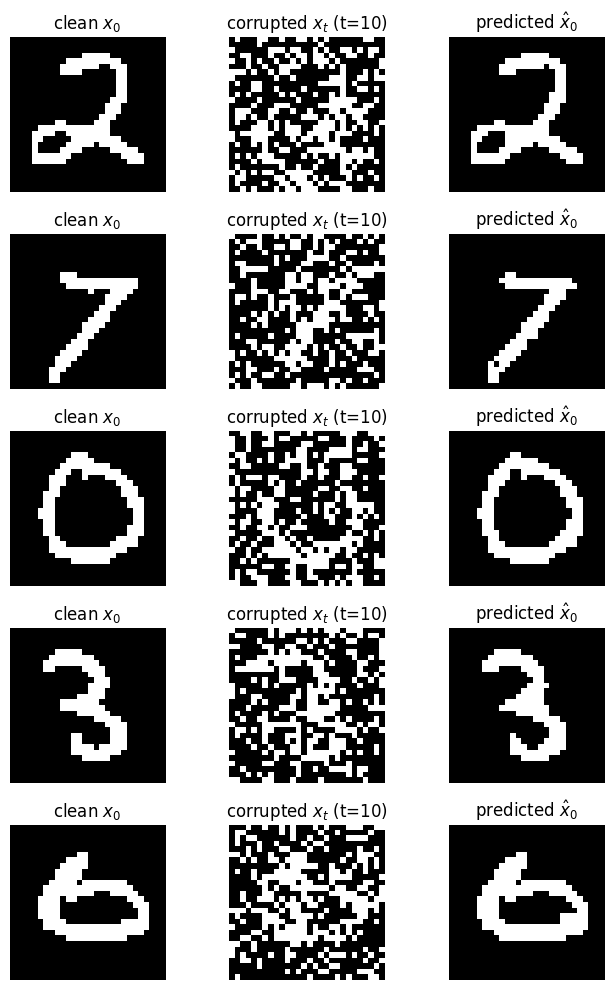

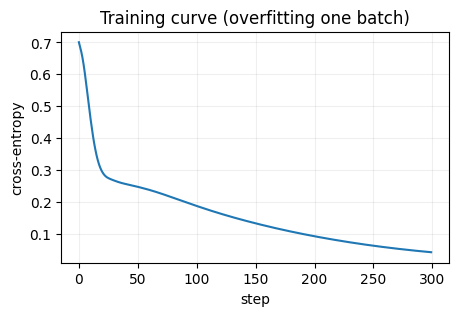

In [ ]:
@torch.no_grad()
def show_denoising_examples(model: nn.Module, x0: torch.Tensor, x_t: torch.Tensor, t: int, n: int = 8):
    model.eval()
    B = x0.shape[0]
    t_vec = torch.full((B,), t, device=x0.device, dtype=torch.long)

    logits = model(x_t, t_vec)              # [B,K,H,W]
    xhat = logits.argmax(dim=1)             # [B,H,W]

    acc_in = (x_t == x0).float().mean().item()
    acc_out = (xhat == x0).float().mean().item()
    print(f"Pixel accuracy at t={t}: input x_t={acc_in:.3f} | predicted xhat={acc_out:.3f}")

    n = min(n, B)
    fig, axes = plt.subplots(n, 3, figsize=(7, 2 * n))
    if n == 1:
        axes = axes.reshape(1, 3)

    x0_cpu = x0[:n].cpu()
    xt_cpu = x_t[:n].cpu()
    xhat_cpu = xhat[:n].cpu()

    for i in range(n):
        axes[i, 0].imshow(x0_cpu[i], vmin=0, vmax=K - 1, cmap="gray")
        axes[i, 0].set_title("clean $x_0$")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(xt_cpu[i], vmin=0, vmax=K - 1, cmap="gray")
        axes[i, 1].set_title(f"corrupted $x_t$ (t={t})")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(xhat_cpu[i], vmin=0, vmax=K - 1, cmap="gray")
        axes[i, 2].set_title(r"predicted $\hat{x}_0$")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


# If you used the version that returns model:
show_denoising_examples(model, x0_fixed, xT_fixed, t=T, n=5)

plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.title("Training curve (overfitting one batch)")
plt.xlabel("step")
plt.ylabel("cross-entropy")
plt.grid(alpha=0.2)
plt.show()


## Short questions

**Question 1.** In this discrete corruption process (binary MNIST, $K=2$), what is the analogue of “noise increasing” from the continuous case?

**Answer 1.**  
In Exercise B, “more noise” meant larger $\sigma(t)$, so $x_t$ becomes less informative about $x_0$. Here, “more noise” means larger $\beta_t$, so a larger fraction of pixels are replaced by random bits. As $\beta_t$ increases, $x_t$ looks more random and the dependence between $x_t$ and $x_0$ decreases.

---

**Question 2.** What does $\beta_t$ control, and what are the limiting behaviors at $\beta_t=0$ and $\beta_t=1$?

**Answer 2.**  
$\beta_t$ is the per-pixel probability of replacement. If $\beta_t=0$, nothing changes and $x_t=x_0$. If $\beta_t=1$, every pixel is resampled uniformly in $\{0,1\}$, so $x_t$ is i.i.d. $\mathrm{Bernoulli}(0.5)$ and (in this toy model) independent of $x_0$. For $K=2$, replacement does not always flip the bit.

---

**Question 3.** In the model input we concatenate the corrupted image $x_t$ and a “time channel” containing $t/T$. Why include $t$ explicitly?

**Answer 3.**  
For the same reason as in Exercise B: the correct denoising behavior depends on the noise level. Providing $t$ tells the network how strong the corruption is, so it can adapt across noise strengths instead of trying to infer the noise level from $x_t$ alone.

---

**Question 4.** This notebook overfits one fixed batch at a fixed $t=T$. What does a decreasing training loss show, and what does it not show?

**Answer 4.**  
It shows the corruption function, model wiring, and cross-entropy loss are consistent, and that the network can fit the denoising mapping on that specific batch at that specific noise level (a wiring sanity check). It does not show generalization to new images, performance at other time steps, or the ability to generate samples from noise.

---

**Question 5.** After confirming the fixed-$t$ sanity check works, what is the immediate next step to make training closer to the continuous diffusion training you saw?

**Answer 5.**  
Train across multiple noise levels: sample $t \sim \mathrm{Uniform}\{1,\dots,T\}$, corrupt $x_0 \to x_t$ using $\beta_t$, and minimize the average cross-entropy over timesteps (and batches). This is the discrete analogue of training on randomly sampled noise levels in Exercise B.

---

**Question 6.** In the VAE notebook, the objective had reconstruction + KL. In this discrete denoising toy example we only minimize cross-entropy. Which VAE term does cross-entropy correspond to, and what VAE term is missing? Also, compared to the continuous diffusion pipeline, what major ingredient is still missing if we want to *generate* samples from noise?

**Answer 6.**  
Cross-entropy corresponds to the **reconstruction** term (a negative log-likelihood). The **KL** term is missing; in a VAE it regularizes the latent distribution toward the prior so sampling from the prior produces meaningful outputs. Compared to continuous diffusion, we are still missing an explicit **multi-step denoising procedure** that starts from a highly corrupted $x_T$ (noise) and iteratively denoises back toward a sample, rather than doing a single-step prediction $x_t \to \hat{x}_0$.
